In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from entropy import spectral_entropy

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import Audio

import keras

In [4]:
Ravdess = "/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/"
Crema = "/home/kenterbery/projects/speech_emotion_recognition/input/Crema/"
Savee = "/home/kenterbery/projects/speech_emotion_recognition/input/Savee/"
Tess = "/home/kenterbery/projects/speech_emotion_recognition/input/Tess/"

Ravdess dataset

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, Ravdess + dir + "/" + wav))

In [6]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [7]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotion                                               Path
0  neutral  /home/kenterbery/projects/speech_emotion_recog...
1  neutral  /home/kenterbery/projects/speech_emotion_recog...
2  disgust  /home/kenterbery/projects/speech_emotion_recog...
3  disgust  /home/kenterbery/projects/speech_emotion_recog...
4  disgust  /home/kenterbery/projects/speech_emotion_recog...

Crema dataset


In [8]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + wav))
    else:
        emotion_df.append(("unknown", Crema + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

Emotion                                               Path
0  disgust  /home/kenterbery/projects/speech_emotion_recog...
1    happy  /home/kenterbery/projects/speech_emotion_recog...
2      sad  /home/kenterbery/projects/speech_emotion_recog...
3    happy  /home/kenterbery/projects/speech_emotion_recog...
4  neutral  /home/kenterbery/projects/speech_emotion_recog...

TESS dataset

In [9]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(Tess + dir):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", Tess + dir + "/" + wav))
        else:
            emotion_df.append((emo, Tess + dir + "/" + wav))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

Emotion                                               Path
0     sad  /home/kenterbery/projects/speech_emotion_recog...
1     sad  /home/kenterbery/projects/speech_emotion_recog...
2     sad  /home/kenterbery/projects/speech_emotion_recog...
3     sad  /home/kenterbery/projects/speech_emotion_recog...
4     sad  /home/kenterbery/projects/speech_emotion_recog...

In [10]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + wav))
    else:
        emotion_df.append(("surprise", Savee + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

Emotion                                               Path
0      sad  /home/kenterbery/projects/speech_emotion_recog...
1  neutral  /home/kenterbery/projects/speech_emotion_recog...
2  disgust  /home/kenterbery/projects/speech_emotion_recog...
3    angry  /home/kenterbery/projects/speech_emotion_recog...
4  disgust  /home/kenterbery/projects/speech_emotion_recog...

In [11]:
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [12]:
df.head()

Emotion                                               Path
0  neutral  /home/kenterbery/projects/speech_emotion_recog...
1  neutral  /home/kenterbery/projects/speech_emotion_recog...
2  disgust  /home/kenterbery/projects/speech_emotion_recog...
3  disgust  /home/kenterbery/projects/speech_emotion_recog...
4  disgust  /home/kenterbery/projects/speech_emotion_recog...

### Exploratory data analysis


In [13]:
%matplotlib inline

plt.style.use("ggplot")

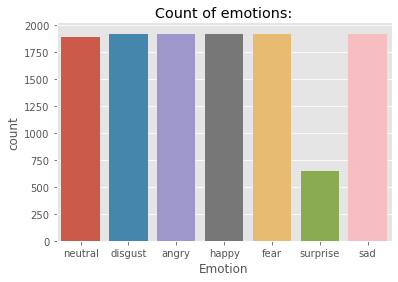

In [14]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [15]:
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10,3))
    plt.title(f"Waveplot for .wav with {emo} emotion")
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emo):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12,3))
    plt.title(f"Spectrogram for .wav with {emo} emotion")
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz")
    # librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar()


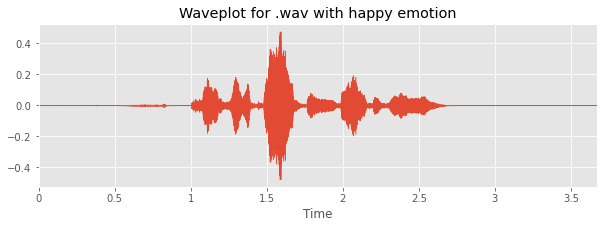

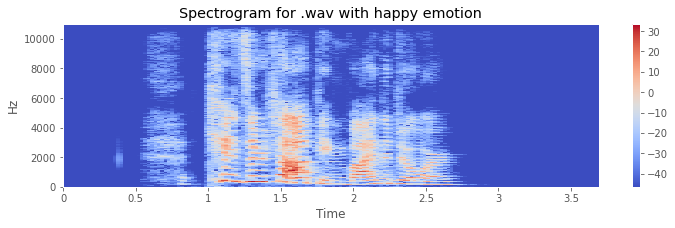

In [16]:
emotion = "happy"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

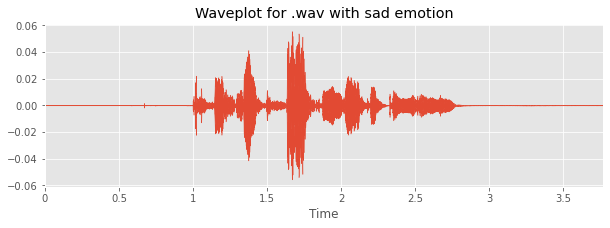

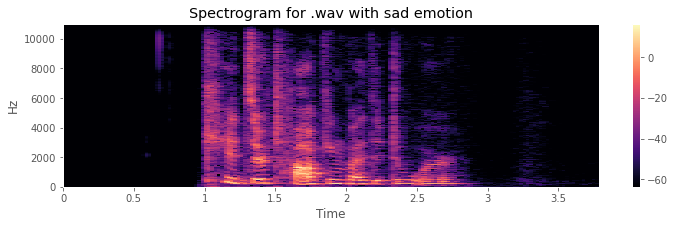

In [17]:

emotion = "sad"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

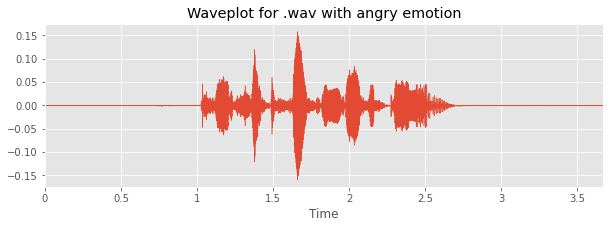

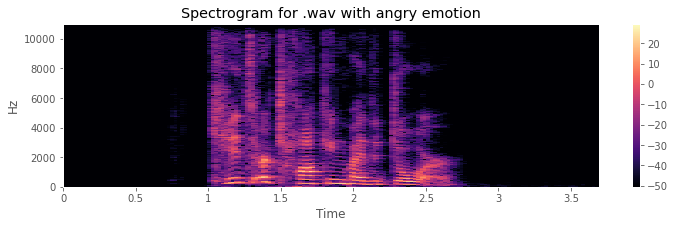

In [18]:
emotion = "angry"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

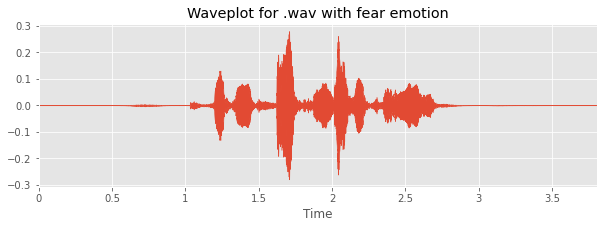

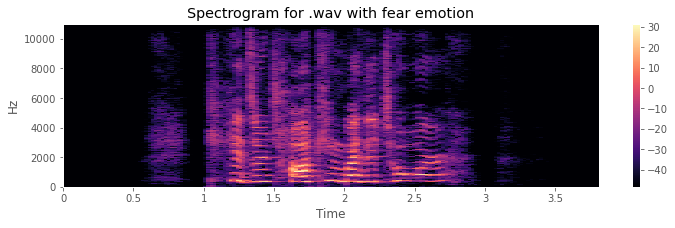

In [19]:
emotion = "fear"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Data augmentation

In [20]:
def noise(data, rate=0.035):
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [21]:
path = np.array(df.Path)[100]
data, sampling_rate = librosa.load(path)

1. Simple audio

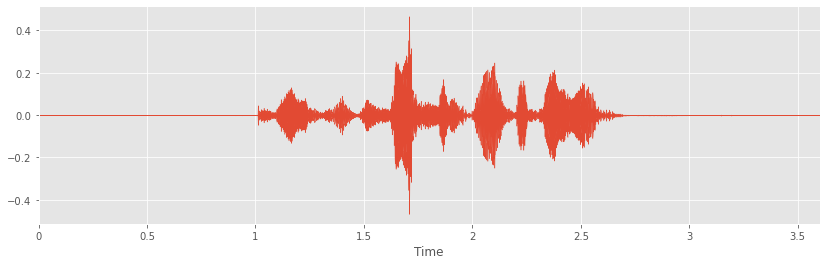

In [22]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

2. Noised audio

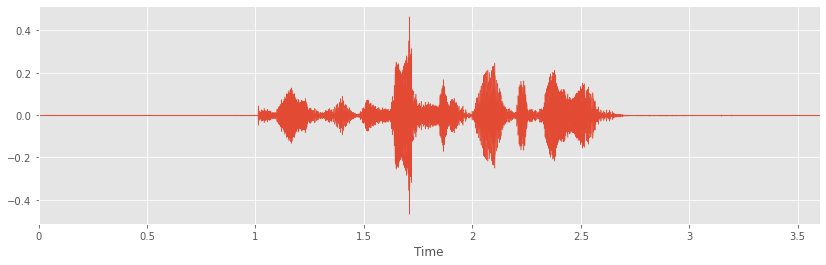

In [23]:
noised_data = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


3. Stretching


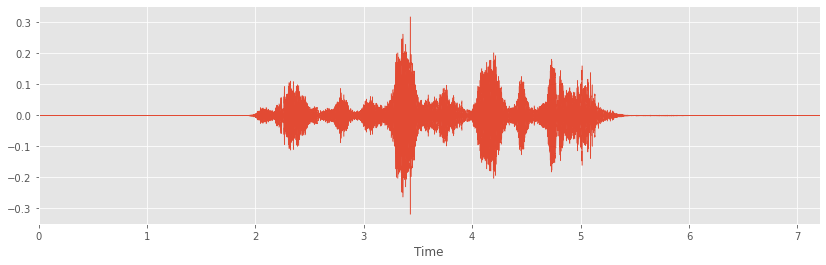

In [24]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

4. Shifting


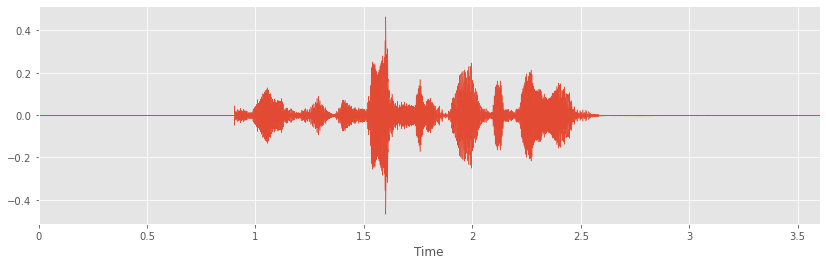

In [25]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


5. Pitching

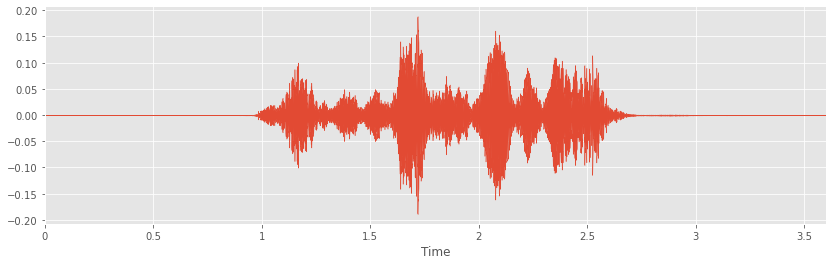

In [26]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For data augmentation we will use noise, shift and pitch


### Feature extraction

#### Features which may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [49]:
n_fft = 2048
hop_length = 512

In [194]:
def chunks(data, frame_length, hop_length):
    """
    Split data to chunks with size frame_length and every hop_length.
    :param data: np.array
    :param frame_length: Int
    :param hop_length: Int
    :return: <generator>
    """
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(zcr), axis=0)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(rmse), axis=0)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(spectral_centroid), axis=0)


def spc_entropy(data, sr):
    spc_en = spectral_entropy(data, sf=sr, method="fft")
    return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.mean(np.squeeze(vsf)) if isSpectrum else np.mean(vsf)


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(spcrollof), axis=0)


def chroma_stft(data, sr, frame_length=2048, hop_length=512):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(np.squeeze(chroma_stft.T), axis=0)


def mel_spc(data, sr, frame_length=2048, hop_length=512):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.mean(np.squeeze(mel.T), axis=0)

#### Let's check data formats:

In [196]:
print("ZCR: ", zcr(data))
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data))
print("Spectral Centroid :", spc(data, sampling_rate))
print("Spectral Entropy: ", spc_entropy(data, sampling_rate))
print("Spectral Flux: ", spc_flux(data))
print("Spectral Rollof: ", spc_rollof(data, sampling_rate))
print("Chroma STFT: ", chroma_stft(data, sampling_rate))
print("MelSpectrogram: ", mel_spc(data, sampling_rate))

ZCR:  0.24193617876838236
Energy:  (136,)
Entropy of Energy : (136,)
RMS : 0.0016241048
Spectral Centroid : 2840.838371228717
Spectral Entropy:  10.814385
Spectral Flux:  0.0
Spectral Rollof:  5951.080681295956
Chroma STFT:  [0.72231877 0.777779   0.7992358  0.73897886 0.69619405 0.65146375
 0.7058066  0.75501364 0.79087305 0.8107662  0.78569984 0.7255167 ]
MelSpectrogram:  [3.44214714e-05 9.19141967e-05 2.27494515e-03 9.61299613e-03
 4.92502144e-03 1.11557450e-03 2.57051527e-03 1.24718910e-02
 1.21993050e-02 4.45828540e-03 5.50416205e-03 5.58328116e-03
 6.88322587e-03 3.54128331e-03 1.30247530e-02 2.72754077e-02
 2.36709900e-02 9.31603741e-03 6.61813654e-03 7.31731020e-03
 8.48080590e-03 6.63679000e-03 9.28076077e-03 3.53128067e-03
 1.79563696e-03 5.77044440e-03 2.17673625e-03 8.09165649e-04
 6.68623310e-04 1.18246546e-03 6.33835851e-04 1.81278519e-04
 9.11733005e-05 1.12080343e-04 1.60289273e-04 1.43897705e-04
 4.26793762e-04 6.83494378e-04 3.14349600e-04 8.63866007e-04
 3.03582987e-

In [198]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        np.mean(energy(data, frame_length, hop_length),axis=0),
                        np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        spc(data, sr, frame_length, hop_length),
                        spc_entropy(data, sr),
                        spc_flux(data),
                        spc_rollof(data, sr, frame_length, hop_length),
                        chroma_stft(data, sr, frame_length, hop_length),
                        mel_spc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [199]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [206]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log2
/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/python3.7/site-packages/entropy/entropy.py:174: RuntimeWarning: divide by zero encountered in log2
  se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/python3.7/site-packages/entropy/entropy.py:174: RuntimeWarning: invalid value encountered in multiply
  se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log2
/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/pytho

In [210]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv("features.csv", index=False)
extracted_df.head()

0         1         2         3            4          5    6  \
0  0.204373  0.000010  0.050576  0.002128  2235.690019  10.279838  0.0   
1  0.182893  0.000010  0.050581  0.002132  2871.324116  10.280453  0.0   
2  0.096072  0.000002  0.043583  0.000915  2242.687474  10.774828  0.0   
3  0.251343  0.000009  0.047827  0.001971  2672.442553  10.606226  0.0   
4  0.320507  0.000010  0.049659  0.002328  4347.680894  10.950564  0.0   

             7         8         9  ...           139           140  \
0  4838.690186  0.718762  0.723420  ...  4.479193e-07  9.569317e-07   
1  5498.942057  0.712519  0.727501  ...  4.940236e-07  1.000280e-06   
2  4855.099284  0.712787  0.708226  ...  8.863117e-08  1.122525e-07   
3  5451.788330  0.666190  0.727316  ...  6.474995e-07  7.165393e-07   
4  8320.788574  0.761702  0.802776  ...  3.036423e-05  3.209472e-05   

            141           142           143           144           145  \
0  3.863719e-07  3.854904e-07  9.495682e-07  1.371578e-06  1.315227e-06   
1  4.358499e-07  4.338287e-07  9.829454e-07  1.410190e-06  1.345396e-06   
2  1.370185e-07  1.678324e-07  6.157283e-08  1.318991e-07  2.058994e-07   
3  1.602465e-06  2.164207e-06  2.434297e-06  3.643343e-06  3.485506e-06   
4  3.500826e-05  3.518106e-05  3.421423e-05  3.601180e-05  3.741927e-05   

            146           147   labels  
0  4.434247e-07  1.838895e-08  neutral  
1  4.813936e-07  6.247265e-08  neutral  
2  6.038739e-08  5.613277e-09  neutral  
3  8.515947e-07  5.628826e-08  neutral  
4  3.374478e-05  3.247713e-05  neutral  

[5 rows x 149 columns]

In [2]:
extracted_df = pd.read_csv("features.csv")
print(extracted_df.shape)

extracted_df.dropna(inplace=True)
extracted_df.shape

(36486, 149)


(35886, 149)

### Data preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [3]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [4]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
Y.shape

(35886, 7)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28708, 148), (7178, 148), (28708, 7), (7178, 7))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((25837, 148), (7178, 148), (2871, 148), (25837, 7), (7178, 7), (2871, 7))

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((25837, 148), (7178, 148), (2871, 148), (25837, 7), (7178, 7), (2871, 7))

In [8]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((25837, 148, 1),
 (7178, 148, 1),
 (2871, 148, 1),
 (25837, 7),
 (7178, 7),
 (2871, 7))

In [34]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 10,
                              restore_best_weights = True)


In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.4,
                                            min_lr=0.00001)

In [36]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
model = models.Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])



In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 148, 256)          1536      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 74, 256)           327936    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 37, 256)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 37, 256)           327936    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 19, 256)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 19, 128)          

In [39]:
EPOCHS = 50
batch_size = 64

In [40]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
808/808 [==============================] - 126s 156ms/step - loss: 1.5438 - acc: 0.3790 - f1_m: 0.2186 - val_loss: 1.4016 - val_acc: 0.4434 - val_f1_m: 0.2953
Epoch 2/50
808/808 [==============================] - 116s 143ms/step - loss: 1.3183 - acc: 0.4740 - f1_m: 0.3747 - val_loss: 1.3066 - val_acc: 0.4943 - val_f1_m: 0.4115
Epoch 3/50
808/808 [==============================] - 120s 149ms/step - loss: 1.2515 - acc: 0.5063 - f1_m: 0.4175 - val_loss: 1.2330 - val_acc: 0.5106 - val_f1_m: 0.3945
Epoch 4/50
808/808 [==============================] - 118s 146ms/step - loss: 1.2178 - acc: 0.5196 - f1_m: 0.4371 - val_loss: 1.2200 - val_acc: 0.5249 - val_f1_m: 0.4120
Epoch 5/50
808/808 [==============================] - 115s 142ms/step - loss: 1.1860 - acc: 0.5336 - f1_m: 0.4563 - val_loss: 1.2544 - val_acc: 0.5169 - val_f1_m: 0.4464
Epoch 6/50
808/808 [==============================] - 117s 144ms/step - loss: 1.1741 - acc: 0.5403 - f1_m: 0.4658 - val_loss: 1.2043 - val_acc: 0.5165

225/225 [==============================] - 6s 29ms/step - loss: 1.2816 - acc: 0.5879 - f1_m: 0.5714
Accuracy of our model on test data :  58.790749311447144 %


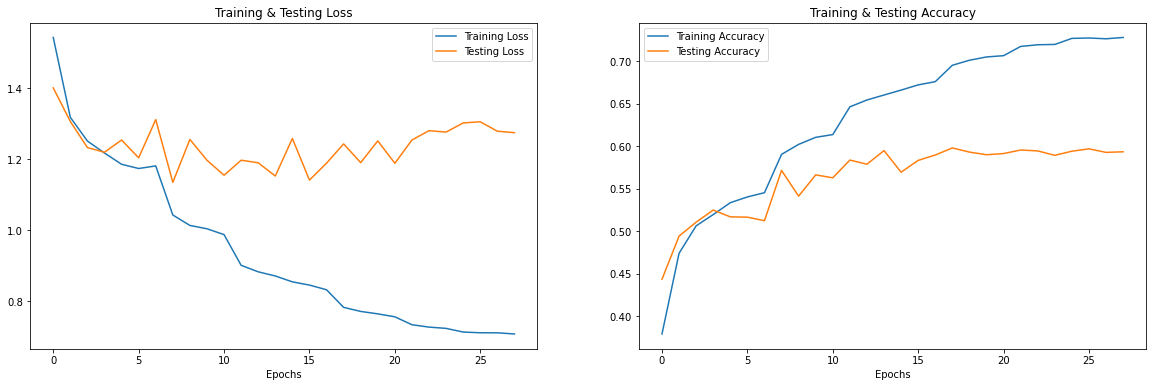

In [44]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(28)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [45]:
model.save(f"50epochs_several_cnn_layers__58.79% acc")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 50epochs_several_cnn_layers__58.79% acc/assets


In [49]:
model1 = keras.models.load_model("50epochs_several_cnn_layers__58.79% acc")

ValueError: Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.